# Probability of Alpha pack draws in R6S


# 1 Introduction

The goal of this notebook is to understand the mechanism of Alpha pack drops a bit better through a simulation. Specifically, the two questions listed below in 1.2 are of relevance. Firstly, let us specify the rules of the Alpha pack draw.

## 1.1 Rules of the Alpha pack drop
0. The initial value of the probability of an Alpha pack dropping is $p_{A}=0.02$ (2 percent).
1. A player plays a match and wins with a probability $p_{win}$.
2. - If the player wins, an Alpha pack drops with probability $p_{A}$. It is simulated as a random sample of a Bernoulli distributed random variable $A\sim\text{Be}(p_A)$.
    - If the Alpha pack dropped: The probability is reset to $p_A=0.02$ (for a moment).
     - If the Alpha pack did not drop: We add $0.02$ to the value of $p_A$.
  - If the player lost the match, we add $0.015$ to the value of $p_A$.

Repeat 1-2 every time you play a match.

### Winning probability vs. Win-Loss
A word about the winning probability $p_{win}$: I just compute the ratio of matches I have won. 
This is obviously not the W/L ratio: Let's say a player has a W/L of 0.5. This player needs to lose twice before winning one match, i.e. on average the player wins one in three matches: $p_{win}=\frac{1}{3}$.

Actually, you can compute your $p_{win}$ using your W/L ratio: Let the W/L ratio be called $R$. Then, the $p_{win}$ is given by:
$$p_{win} = \frac{R}{1+R}.$$

**Proof** by high-school level calculations:
- You play $N$ matches, win $W$ and lose $L$ of them: $N=L+W$
- We are interested in the quantity $p_{win}:=\frac{W}{N}$
- Given is the Win-Loss ratio $R := \frac{W}{L}$.
- $p_{win} = \frac{W}{N} = \frac{W}{L+W}$.
- Thus, $\frac{1}{p_{Win}} = \frac{L+W}{W} = \frac{L}{W} + 1 = \frac{1+R}{R}$.
- Therefore, $p_{win} = \frac{R}{1+R}$.


## 1.2 Main questions

The following questions should get answered:

1. **How many rounds does a player expect to have to play until another Alpha pack drops?**
2. **After each round without an Alpha pack dropping, the probability $p_A$ of an Alpha pack dropping after the next won match increases (either by 1.5 or by 2 percent). What accumulated probability $p_A$ does a player reach *in expectation* until another Alpha pack drops?**

Specifically, we are not just interested in the expectations, but in the probability distributions.

## 1.3 Mathematical model vs. Simulation
A mathematical model is not difficult to write down. In fact, one has to follow the classical derivation of the Geometric distribution, with iid Bernoulli random variables. The only change to be implemented are the different Bernoulli probabilities at each draw. 
I derived a formula pretty quickly, but it does not have a pretty form, and I had to evaluate it numerically. It turns out that a simple simulation of the mechanism is faster to write and the result does not significantly derive from the simulation.

This is the curse and blessing of the 21st century: With the computational power available to us, simulations are quicker (and at times numerically more accurate) than exact computations with paper and pencil. We (obviously including me) are evolving our brains to degenerate.

# 2 Implementing a player in Python

The first step is to import some libraries.

In [1]:
# Import some standard libraries to python. 
# If you don't have them installed, run 
# pip install numpy matplotlib pandas
# on your bash or PowerShell.

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

Now we can start.

For our considerations, a player is modeled by its probability to win a round. As a modest player myself, I have won roughly $40$ percent of my matches, thus I will set $p_{win}=0.4$.

The parameter `n_matches` corresponds to the number of matches we are going to simulate. Set it to a value which will yield a nice smooth distribution at an acceptable computation time.

In [2]:
p_win = .4
n_matches = int(7e6)

Let us implement the class representing a player. This class has two methods - one to simulate the matches, and one to simulate an Alpha Pack draw after each round. 

A player is represented by its probability `p_win` to win. For the Alpha Pack simulations, the variables `dp_loss` and `dp_win` correspond to the increase in probability which gets awarded after a lost or a won match, respectively. In the present version, these delta values are $1.5$ and $2$ percent, respectively.

The method `sim_alpha_naive` assumes that the matches have already been simulated, goes through all matches, simulates an Alpha Pack draw after each match won, and updates the probability for the next draw. Please note that after a successful draw, the probability is set again to $2$ percent, i.e. to `dp_win`.

In [3]:
class Player:
    def __init__(self, p_win, dp_loss=.015, dp_win=.02):            
        self._p_win = p_win
        self._dp_win = dp_win
        self._dp_loss = dp_loss

    def sim_matches(self, n_matches):
        # simulate matches
        matches = np.random.binomial(1, self._p_win, n_matches)
        # simulate alpha pack draws
        alpha, alpha_prob = self.sim_alpha_naive(matches)
        
        results = pd.DataFrame(data={'Result': matches,
                                     'Alpha Dropped': alpha,
                                     'p[Alpha]': alpha_prob[:n_matches]
                                     })
        
        results['Result']=results['Result'].astype(bool)
        results['Alpha Dropped']=results['Alpha Dropped'].astype(bool)
        return results

    def sim_alpha_naive(self, matches):
        if matches.__len__()==0:
            raise RuntimeError('No rounds simulated yet.')

        # preallocate
        alpha = [None]*matches.__len__()
        alpha_prob = [self._dp_win] + \
                     [None]*(matches.__len__())

        'go through all rounds and simulate alpha draw'
        for k in range(matches.__len__()):
            result = matches[k]

            if not result:
                'if round was lost: update probability'
                get_alpha = 0
                alpha_prob[k+1] = min(1., alpha_prob[k] + self._dp_loss)
            else:
                'if round has been won'
                alpha_draw_prob = alpha_prob[k]
                get_alpha = np.random.binomial(1, alpha_draw_prob, 1)[0]

                if get_alpha:
                    'if alpha dropped: reset probability'
                    alpha_prob[k+1] = self._dp_win
                else:
                    'if no alpha dropped: update probability'
                    alpha_prob[k+1] = min(1., alpha_prob[k] + self._dp_win)

            alpha[k] = get_alpha
        return alpha, alpha_prob        

# 2 Simulate the rounds

We now open an instance of the class and simulate `n_matches` matches.

In [4]:
pl = Player(p_win)
result = pl.sim_matches(n_matches)

Let us look at a typical progression of the probability to win. In the following picture, you will see an excerpt of the simulated data: 

- On the x-axis you see the number $n$ of the simulated match. We randomly choose 300 consecutive matches to display.
- On the y-axis is the probability to draw an Alpha pack after the $n$-th match
- Green dots are won matches. Red dots are lost matches.
- The black line represents the probability.

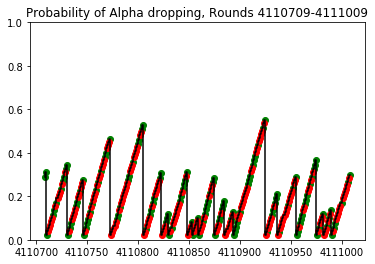

In [5]:
n_samples=300
idx_start = np.random.randint(low=0, high=n_matches-n_samples)
idx_end = idx_start+n_samples

result_plt = result[idx_start:idx_end]
idx_wins = np.where(result_plt['Result'])[0]
idx_loss = np.where(1-result_plt['Result'])[0]

plt.plot(result_plt['p[Alpha]'][idx_start+idx_wins], 'go')
plt.plot(result_plt['p[Alpha]'][idx_start+idx_loss], 'ro')
plt.plot(result_plt['p[Alpha]'], 'k-', drawstyle='steps')
axes = plt.gca()
_ = axes.set_ylim([0,1])

_ = plt.title('Probability of Alpha dropping, Rounds {}-{}'.format(idx_start, idx_end))

What do we observe? Currently, we have set the probability to win a match to 40 percent. From the looks of it, this player will get an Alpha pack at probabilities between 20 and 30 percent. This roughly corresponds to my experience.

# 3 Visualise empirical distributions

The main questions at hand are: **What is the distribution of the number of rounds played until an Alpha pack will drop again? What is the distribution of the probability I have reached at the point when an Alpha pack drops?**

The previous plot (and personal experience) give us an idea: The answer to the first question might be between 10 and 25, the answer to the second question might be somewhere between 20 and 30 percent. 

Now what is the average probability the player will reach when it drops? What about symmetry and tails? Is it almost unlikely a pack will only drop at, say, 80 percent?

Luckily, we have simulated a million matches and will therefore obtain a good idea of how the probability distribution looks.

Let us prepare the data to obtain a good plot.

In [6]:
# get the numbers of the matches after which an Alpha pack dropped
idx_alpha = np.where(result['Alpha Dropped'])[0]
# compute the series of matches to be played until an Alpha pack drops again
matches_till_alpha = np.hstack([idx_alpha[0], np.diff(idx_alpha)])
# compute which probability there was at the time
prob_at_alpha = result['p[Alpha]'][idx_alpha]
# format everything into a DataFrame for a simple workflow
AlphaDropped = pd.DataFrame(data={'Round': idx_alpha,
                                  'Matches to Alpha': matches_till_alpha,
                                  'Probability at Alpha': prob_at_alpha})
_ = AlphaDropped.set_index('Round')

## 3.1 Probability distribution of the probability reached when an Alpha pack drops

We can now visualise the empirical distribution obtained through a simulation. In my case of $p_{win}=0.4$, the Alpha pack probability at the point where an Alpha pack drops is asymmetric around a mean of ca. 25 percent.

The following code formats the DataFrame, computes some basic descriptive stats, and finally plots the histogram of the distribution.

Basic Statistics:

count    473429.000000
mean          0.251334
std           0.127727
min           0.020000
25%           0.155000
50%           0.240000
75%           0.335000
max           1.000000
Name: Probability at Alpha, dtype: float64


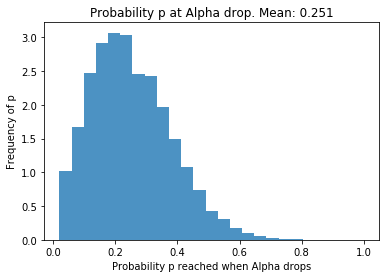

In [7]:
# Print some basic stats
print('Basic Statistics:\n')
_ = print(AlphaDropped['Probability at Alpha'].describe())

# Plot a histogram (normed to ensure unit mass)
AlphaDropped['Probability at Alpha'].plot.hist(bins=25, alpha=.8, density=True)
# Compute the mean
mean = np.round(AlphaDropped['Probability at Alpha'].mean(), 3)
# Define the title of the histogram
plt.title('Probability p at Alpha drop. Mean: {}'.format(mean))
plt.xlabel('Probability p reached when Alpha drops')
_ = plt.ylabel('Probability Density at p')

## 3.2 Probability distribution of the number of matches played until an Alpha pack drops

We can now visualise the empirical distribution obtained through a simulation. In my case of $p_{win}=0.4$, I expect to play on average 14 to 15 matches until I get another Alpha pack. I would also expect to play at most 20 rounds to obtain an alpha pack in three out of four cases. The probability distribution looks similar to the probability distribution of the peak probability as the alpha pack drops - that follows a certain logic. 

The following code formats the DataFrame, computes some basic descriptive stats, and finally plots the histogram of the distribution.

Basic Statistics:

count    473429.000000
mean         14.785708
std           7.688753
min           1.000000
25%           9.000000
50%          14.000000
75%          20.000000
max          62.000000
Name: Matches to Alpha, dtype: float64


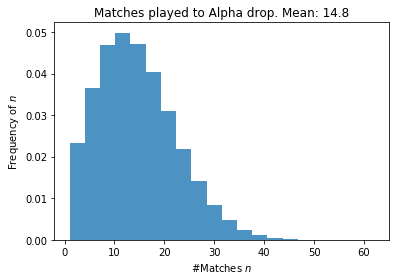

In [8]:
# Print some basic stats
print('Basic Statistics:\n')
_ = print(AlphaDropped['Matches to Alpha'].describe())

# Plot a histogram (normed to ensure unit mass)
AlphaDropped['Matches to Alpha'].plot.hist(bins=20, alpha=.8, density=True)
# Compute the mean
mean = np.round(AlphaDropped['Matches to Alpha'].mean(), 1)
# Define the title of the histogram
plt.title('Matches played to Alpha drop. Mean: {}'.format(mean))
plt.xlabel('#Matches $n$')
_ = plt.ylabel('Probability Density at $n$')

